### Imports:

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from PIL import Image
import os
from tqdm import tqdm

import cv2
import skimage

from scipy.ndimage import binary_fill_holes
from skimage import img_as_ubyte
from skimage.color import rgb2gray, rgb2hsv
from skimage.exposure import equalize_hist, histogram
from skimage.feature import canny
from skimage.filters import threshold_otsu, unsharp_mask, gaussian
from skimage.measure import find_contours, approximate_polygon
from skimage.morphology import (dilation, erosion, binary_closing, binary_opening, remove_small_holes,
                                remove_small_objects, thin, convex_hull_image, square, disk, diamond, octagon, star, skeletonize)
from skimage.util import invert

from skimage.measure import label, regionprops

from scipy.signal import argrelmin, argrelmax, argrelextrema
from scipy.spatial import distance_matrix

In [2]:
def to_1ch(img, mode='gray'):
    transf_1ch = (
        {'r': lambda img: img[:, :, 0],
         'g': lambda img: img[:, :, 1],
         'b': lambda img: img[:, :, 2],
         'h': lambda img: img_as_ubyte(rgb2hsv(img)[:, :, 0]),
         's': lambda img: img_as_ubyte(rgb2hsv(img)[:, :, 1]),
         'v': lambda img: img_as_ubyte(rgb2hsv(img)[:, :, 2]),
         'gray': lambda img: img_as_ubyte(rgb2gray(img))}
    )
    return transf_1ch[mode](img)

In [3]:
def to_bin(img, thr='otsu'):
    if thr == 'otsu':
        return img > threshold_otsu(img)
    else:
        if thr < 1:
            return img > 255 * thr
        else:
            return img > thr

In [4]:
def to_uint8(img):
    img = img.astype(np.float)
    max_ = img.max()
    min_ = img.min()
    if min_ == max_:
        # constant image
        if max_:
            img *= 255 / max_
    elif min_ != 0 or max_ != 255:
        img = (img - min_) / (max_ - min_) * 255
    return img.astype(np.uint8)

In [5]:
def set_padding(img, num, val=False):
    if num > 0:
        h, w = img.shape
        new_img = np.full((h + 2 * num, w + 2 * num), val)
        new_img[num:-num, num:-num] = img
        img = new_img.astype(img.dtype)
    elif num < 0:
        num = -num
        img = img[num:-num, num:-num]
    return img

In [6]:
def resize_prop(img, max_size):
    h, w = img.shape[:2]
    img_max_size = max(w, h)
    if max_size < img_max_size:
        ratio = img_max_size / max_size
        w, h = int(w / ratio), int(h / ratio)
        
        img = cv2.resize(img, (w, h),
                         interpolation=cv2.INTER_AREA)
    return img

In [7]:
def img_sub(img1, img2):
    src_dtype = img1.dtype
    img1, img2 = list(map(lambda x: x.astype(np.int32), [img1, img2]))

    img = img1 - img2
    img[img < 0] = 0

    img = img.astype(src_dtype)
    return img

In [8]:
def sharpen(img, size, count):
    img_blur = cv2.GaussianBlur(img, (size,size), 0)
    img = cv2.addWeighted(img, count + 1, img_blur, -count, 0)
    return img

In [9]:
def list_get(list_, ind_, default_):
  try:
    return list_[ind_]
  except IndexError:
    return default_

def show_images(img_arr, name_arr=[], n_in_row=3, factor_r=8, factor_c=8, figsize=None,
         title=None, cmap_='Greys', label_fontsize=12, tick_fontsize=11, save_path=None):
    if type(img_arr) is np.ndarray:
        quant = img_arr.shape[0]
    elif type(img_arr) is list:
        quant = len(img_arr)
    cols = min(quant, n_in_row)
    rows = quant // n_in_row + (1 if quant % n_in_row else 0)
    if figsize is None:
        figsize = (int(factor_c * cols), int(factor_r * rows))
    fig = plt.figure(figsize=figsize)
    if title is not None:
        fig.suptitle(title, fontsize=14, y = 0.88)
    for i, img in enumerate(img_arr):
        ax = fig.add_subplot(rows, cols, i + 1)
        if type(img) is tuple:
            x, y = img
            ax.plot(x, y)
            ax.set_xlabel(list_get(name_arr, i, ''), fontsize=label_fontsize)
        else:
            ax.imshow(img, cmap=cmap_)
#             print(name_arr[i], len(img_arr), len(name_arr))
            ax.set_xlabel(list_get(name_arr, i, ''), fontsize=label_fontsize)
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            ax.xaxis.set_ticks_position('top')
            ax.tick_params(axis='both', labelsize=tick_fontsize)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(f'{save_path}.pdf', bbox_inches='tight')
    plt.show()

In [10]:
def show_images_cv(img_arr, name_arr=[]):
    for i, img in enumerate(img_arr):
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = resize_prop(img, 700)
        cv2.imshow(list_get(name_arr, i, f'{i}'), img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [11]:
def apply_text(img, fig_text, coords, delta=(0,0), padding=(2, 3), bg_color=(255, 255, 255), font_scale=1.0, font=cv2.FONT_HERSHEY_DUPLEX):
    text_width, text_height = cv2.getTextSize(fig_text, font, fontScale=font_scale, thickness=1)[0]
    text_offset_x, text_offset_y = coords
    text_offset_x += delta[0]
    text_offset_y += delta[1]
    box_coords = ((text_offset_x - padding[0],
                   text_offset_y + padding[1]),
                  (text_offset_x + text_width + padding[0],
                   text_offset_y - text_height - padding[1]))
    cv2.rectangle(img, box_coords[0], box_coords[1], bg_color, cv2.FILLED)
    cv2.putText(img, fig_text, (text_offset_x, text_offset_y),
                font, fontScale=font_scale, color=(0, 0, 0), thickness=1)

In [12]:
def get_dist(p1, p2):
    p1, p2 = np.array(p1), np.array(p2)
    return np.sqrt(np.sum((p1 - p2)**2, axis=-1))

In [13]:
def get_angle(p1, p2, p3):
    a, b, c = (np.sqrt(np.sum((p3 - p1) ** 2, axis=-1)),
               np.sqrt(np.sum((p2 - p1) ** 2, axis=-1)),
               np.sqrt(np.sum((p2 - p3) ** 2, axis=-1)))
    return np.arccos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c))

### Functions

In [14]:
def descend_bin(img, factor=0.5, thr_a=0, thr_b=255, add_a=0, add_b=0, vis=False):
    y, x = list(map(np.array, histogram(img)))
    
    y_mean = np.mean(y)
    y_med = np.median(y)
    thr = y_med + np.abs(y_mean - y_med) * factor

    i0 = np.argmax(y)  
    i1, i2 = i0, i0
    i_min, i_max = 0, thr_b - thr_a

    for i in range(i0, i_min - 1, -1):
        if not (y[i] > thr):
            i1 = i
            break
        
    for i in range(i0, i_max + 1):
        if not (y[i] > thr):
            i2 = i
            break
            
    x1, x2 = x[i1], x[i2]
    
    x1 += add_a
    if x1 > 255:
        x1 = 255
    elif x1 < 0:
        x1 == 0

    x2 += add_b
    if x2 > 255:
        x2 = 255
    elif x2 < 0:
        x2 == 0

    img = img >= x2
    
    if vis:
        fig = plt.figure(figsize=(8, 8))
        plt.plot(x, y, label='y, histogram')

        y_mean_arr = np.full_like(y, y_mean)
        y_med_arr = np.full_like(y, y_med)
        thr_arr = np.full_like(y, thr)

        plt.plot(x, y_mean_arr, label='y mean')
        plt.plot(x, y_med_arr, label='y median')
        plt.plot(x, thr_arr, label='threshold')

        plt.plot(x1, y[i1], 'bo', label='left bound')
        plt.plot(x2, y[i2], 'ro', label='right bound')

        plt.legend()
        plt.tick_params(axis='both')
        plt.tight_layout()
    return img

def get_point_ind(arr, point):
    # getting ind of point in contour
    arr = sorted(np.argwhere(arr == point), key=lambda x: x[0])
    l = len(arr)
    for i in range(l - 1):
        if arr[i][0] == arr[i+1][0]:
            return arr[i][0]

def get_extremes(p_arr, center, mode, window, top_k=None, remove_dup=True):
    p_arr_src = np.copy(p_arr)
    d_arr = distance_matrix(center, p_arr)[0]
    
    # getting extremes
    comparator = None
    if mode == 'max':
        comparator = lambda x1, x2: x1 >= x2
    elif mode == 'min':
        comparator = lambda x1, x2: x1 <= x2
    else:
        assert 0==1
    inds = argrelextrema(d_arr, comparator, order=window, mode='wrap')[0] 
    p_arr = p_arr[inds]
    d_arr = d_arr[inds]
    
    # removing close false extremes in sliding window
    if remove_dup:
        inds = [get_point_ind(p_arr_src, np.array(p)) for p in p_arr]
        inds, d_arr = contour_pruning(inds, d_arr, len(p_arr_src), window=20)
        p_arr = p_arr_src[inds]

    # getting top-k mode extremes
    if top_k is not None:
        inds = np.argsort(d_arr)
        p_arr = p_arr[inds]
        d_arr = d_arr[inds]

        if mode == 'max':
            p_arr = p_arr[-top_k:]
            d_arr = d_arr[-top_k:]
        elif mode == 'min':
            p_arr = p_arr[:top_k]
            d_arr = d_arr[:top_k]
        else:
            assert 0 == 1
        
        # sorting points in order of source contour after applying top-k slice
        inds = np.array(sorted(np.arange(len(p_arr)),
                               key=lambda x: get_point_ind(p_arr_src, np.array(p_arr[x]))))
        p_arr = p_arr[inds]
        d_arr = d_arr[inds]

    return p_arr, d_arr

def get_top_area(mask, k=1):
    # getting regions, sorting them by area and slicing
    labels = label(mask, connectivity=2)
    props = sorted(regionprops(labels),
                   key=lambda p: p.area, reverse=True)[:k]
    
    # removing other not-top-k regions
    m = np.ones_like(mask) > 0
    for p in props:
        m *= (labels != p.label)
    mask[m] = 0

    return mask > 0

def get_neighborhood(mask, point, radius):
    # getting mask of neighborhood
    m = np.zeros_like(mask)
    cv2.circle(m, tuple(point), radius, (255, 255, 255), -1)
    m = mask * m

    # getting all components in neighborhood
    labels = label(m, connectivity=2)
    props = regionprops(labels)

    # leaving only one component that contains the point
    point_mask = np.zeros_like(mask)
    point_mask[tuple(point[::-1])] = 255
    region = None
    for p in props:
        region = (labels == p.label)
        if np.array(np.nonzero(region * point_mask)).size:
            break

    return region

def contour_pruning(arr, dist_arr, length, window=20):
    src_arr = np.copy(arr)
    arr = list(arr)
    l = len(arr)
    
    if l==1:
        return src_arr, dist_arr

    # finding false extremes in sliding window
    flaws_arr = []
    chk_new = True
    chk_cycle = False
    inds = np.arange(l)
    mask = ((np.array(arr) - np.array(arr[-1:] + arr[:-1])) % length) < window
    for i in range(l):
        if mask[i]:
            if i == 0:
                chk_cycle = True
            if chk_new:
                flaws_arr.append([inds[(i - 1) % l], inds[i]])
                chk_new = False
            else:
                flaws_arr[-1].append(inds[i])
                
            if chk_cycle and i == l - 1:
                last = flaws_arr.pop()[:-1]
                flaws_arr[0] += last
        else:
            chk_new = True
    
    # collecting bad and the best inds from bad regions of contour
    all_flaws, right_inds = [], []
    for flaw in flaws_arr:
        all_flaws += flaw
        right_inds.append(sorted(flaw, key=lambda x: dist_arr[x])[-1])
    
    # collecting all new inds of contour
    right_inds = np.array(sorted(set(inds) ^ set(right_inds) ^ set(all_flaws)))

    return src_arr[right_inds], dist_arr[right_inds]

def circle_line_cropper(img, center, radius, point, no_crop=False):
    # O is a center of circle, C is an anchor point
    x_o, y_o = center
    x_c, y_c = point
    
    # checking vertical or horizontal cropping line
    chk_x, chk_y = True, True
    if x_o - x_c == 0:
        chk_x = False
    if y_o - y_c == 0:
        chk_y = False
    
    # getting circle and line intersection coords
    alpha, beta = None, None
    if not chk_x and not chk_y:
        assert 0 == 1
    elif not chk_x:
        alpha = 1
        beta = 1
    else:
        alpha = (y_o - y_c) / (x_o - x_c)
        beta = np.sqrt(1 + alpha**2)
    intersection_arr = np.vstack([np.array([x_o + chk_x * (radius / beta),
                                            y_o + alpha * radius / beta]),
                                  np.array([x_o - chk_x * (radius / beta),
                                            y_o - alpha * radius / beta])])
    c_arr = np.vstack([np.array([x_c, y_c]),np.array([x_c, y_c])])
    ind = np.argmax(np.sqrt(np.sum((intersection_arr - c_arr)**2, axis=1)))
    intersection = intersection_arr[ind].astype(np.int)

    # getting bounding image coords
    bound_points = np.array([[0, 0], img.shape[:2][::-1]])
    
    # getting bounding coords of cropping region on cropping line
    p1 = np.copy(bound_points[0])
    p2 = np.copy(bound_points[1])
    if not chk_y:
        p1[0] = intersection[0]
        p2[0] = intersection[0]
    elif not chk_x:
        p1[1] = intersection[1]
        p2[1] = intersection[1]    
    else:
        f = lambda x: intersection[1] - (x - intersection[0]) / alpha
        p1[1] = f(p1[0])
        p2[1] = f(p2[0])
    
    # getting bounding coords of cropping region on image border
    p3 = np.copy(p2)
    p4 = np.copy(p1)
    if not chk_y:
        ind = 1 if x_c < intersection[0] else 0
        p3[0] = bound_points[ind][0]
        p4[0] = bound_points[ind][0]
    elif not chk_x:
        ind = 1 if y_c < intersection[1] else 0
        p3[1] = bound_points[ind][1]
        p4[1] = bound_points[ind][1]
    else:
        ind = 1 if y_c < f(x_c) else 0
        p3[1] = bound_points[ind][1]
        p4[1] = bound_points[ind][1]
    
    # coords to removing
    crop_coords = np.array([p1, p2, p3, p4])
    if not no_crop:
        cv2.fillPoly(img, [crop_coords], color=(0, 0, 0))

    return img, tuple(intersection), crop_coords

def get_top_defects(contour, k=1):    
    hull = cv2.convexHull(contour)
    hull_inds = cv2.convexHull(contour, returnPoints=False)
    defects = cv2.convexityDefects(contour, hull_inds)
    
    points_arr = []
    for i in range(defects.shape[0]):
        s,e,f,d = defects[i,0]
        start, end, far = contour[s], contour[e], contour[f]
        points_arr.append([d, start, end, far])

    points_arr = sorted(points_arr, key=lambda x: x[0])[-1:]
    points_arr = np.array([points[1:] for points in points_arr])
    return points_arr[:, 2, :]

def get_dist_to_mask(mask, center):
    points_arr = []
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    for contour in contours:
        contour = contour[:, 0, :]
        points_arr.append(tuple(contour[np.argmin(distance_matrix(np.array([center]), contour))]))
    dist_arr = distance_matrix(np.array([center]), np.array(points_arr))
    return points_arr[np.argmin(dist_arr)], np.min(dist_arr)

## Solution

### Finding hand mask

In [15]:
def smart_bin(img):
    img = np.copy(img)

    mask = descend_bin(img, factor=0.0) > 0

    mask = set_padding(mask, 50, False)
    mask = remove_small_objects(mask, 10000, connectivity=2)
    mask = set_padding(mask, -50)
    return mask

def get_main_mask(img):
    # bluring
    img = cv2.GaussianBlur(img, (5,5), 0)
    
    # removing edges
    v, s, w = 2, 3, 3
    grad_x = cv2.Sobel(img, cv2.CV_64F, v, 0, ksize=s)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, v, ksize=s)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    edges = cv2.addWeighted(abs_grad_x, w, abs_grad_y, w, 0)
    edges = edges * to_bin(edges, 60)
    edges = sharpen(edges, 3, 2.5)
    img = img_sub(img, edges)
    
    # binarization
    mask = smart_bin(img)
    
    # afterprocessing mask
    mask = binary_fill_holes(mask, disk(1))
    mask = remove_small_objects(mask, 100)

    return mask

def get_clean_mask_1(img):
    # binarization
    mask = smart_bin(img)

    # cleaning mask
    mask = thin(mask, 4)
    mask = binary_opening(mask, disk(5))

    # enlarging mask
    mask = dilation(mask, disk(3))
    mask = binary_fill_holes(mask, disk(1))
    mask = binary_closing(mask, disk(3))
    mask = binary_fill_holes(mask, disk(1))

    return mask

def get_clean_mask_2(img):
    # bluring
    img = cv2.GaussianBlur(img, (7, 7), 0)
    
    # binarization
    mask = smart_bin(img)
    
    # thinning
    mask = thin(mask, 2)

    return mask

def get_hand_mask(img):
    # get grayscaled image
    red = to_1ch(img, 'r')
    
    # get image masks
    main_mask = get_main_mask(red) > 0
    mask_1 = get_clean_mask_1(red) > 0
    mask_2 = get_clean_mask_2(red) > 0
    
    # masks logical AND
    res = main_mask * mask_1 * mask_2
    
    # afterprocessing mask
    res = binary_opening(res, disk(1))
    res = remove_small_objects(res, 500)
    res = binary_fill_holes(res, disk(1))
    res = get_top_area(res)
    
    return {'mask': res,
            '1ch': red,
            'mask_0': main_mask,
            'mask_1': mask_1,
            'mask_2': mask_2}

### Getting hand geometry

In [16]:
def get_palm_center(mask):
    # getting skeleton and distance map
    skeleton = to_uint8(skeletonize(mask > 0))
    skeleton = cv2.dilate(skeleton, disk(2)) > 0
    distance = cv2.distanceTransform(to_uint8(mask), cv2.DIST_L2, 5)

    # getting palm center
    coeff = 0.8
    c_arr  = np.where(skeleton * (distance >= coeff * distance[np.where(skeleton)].max()))
    palm_center = np.mean(c_arr, axis=-1).astype(np.int)

    return palm_center, skeleton

def get_hand_geometry(mask, vis_img=None):
    mask = to_uint8(mask)

    # getting palm center and hand skeleton
    palm_center, hand_skeleton = get_palm_center(mask)
    palm_center = tuple(palm_center[::-1])

    # getting hand contour and convex hull
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2:]
    hand_contour = contours[np.argmax([len(contour) for contour in contours])][:, 0, :]
    hand_hull = cv2.convexHull(hand_contour)

    # getting relative minimums for finding palm radius
    hand_mins, hand_mins_dist = get_extremes(hand_contour, np.array([palm_center]), 'min', 100, top_k=6)
    palm_radius = np.median(hand_mins_dist)
    
    # getting hollows_mask
    contour_mask = np.copy(to_uint8(hand_skeleton)) #erosion(mask, disk(3))
    contours, _ = cv2.findContours(contour_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2:]
    contour = contours[np.argmax([len(contour) for contour in contours])][:, 0, :]
    hand_skeleton_hull = cv2.convexHull(contour)
    hand_skeleton_hull_mask = to_uint8(np.zeros_like(mask))
    cv2.drawContours(hand_skeleton_hull_mask, [hand_skeleton_hull], 0, [255, 255, 255], -1)    
    hollows_mask = (invert(mask > 0) > 0) * erosion((hand_skeleton_hull_mask > 0), disk(15))
    
    # getting outer hollow skeleton
    hollows_skeleton = skeletonize(hollows_mask)
    hollows_skeleton = to_uint8(dilation(hollows_skeleton, disk(2)))
    hollows_skeleton = get_top_area(hollows_skeleton, 7)
    
    # getting hollows skeleton centroid = hollows centroid
    props = regionprops(label(hollows_skeleton, connectivity=2))
    hol_centroids = np.array([np.array(p.centroid) for p in props])
    hol_areas = np.array([p.area for p in props])
    
    # method 1 for centroid
    c_arr, a_arr = np.copy(hol_centroids), np.copy(hol_areas)
    a_arr_med = np.median(hol_areas)
    ind_mask = np.argsort(abs(a_arr - a_arr_med))[:4]
    c_arr, a_arr = c_arr[ind_mask], a_arr[ind_mask]
    a_arr_med = np.median(hol_areas)
    ind_mask = abs(a_arr - a_arr_med) < 300
    c_arr, a_arr = c_arr[ind_mask], a_arr[ind_mask]
    res_1 = np.mean([np.mean(c_arr, axis=0),
                     np.average(c_arr, axis=0, weights=a_arr)],
                     axis=0)
    
    # method 2 for centroid
    c_arr, a_arr = np.copy(hol_centroids), np.copy(hol_areas)
    a_arr_med = np.median(hol_areas)
    ind_mask = abs(a_arr - a_arr_med) < 1000
    c_arr, a_arr = c_arr[ind_mask], a_arr[ind_mask]
    res_2 = np.mean([np.mean(c_arr, axis=0),
                     np.average(c_arr, axis=0, weights=a_arr)],
                     axis=0)
    
    # getting final hollows centroid - average of two methods
    hollows_centroid = np.average([res_1, res_2], weights=[0.3, 0.7], axis=0).astype(np.int)
    hollows_centroid = tuple(hollows_centroid[::-1])
    
    # getting cropped mask, wrist and crop coords
    mask, wrist, crop_coords = circle_line_cropper(mask, palm_center, palm_radius, hollows_centroid)
    mask = get_top_area(mask)

    # visualizing: drawing on vis_img
    vis_img_1, vis_img_2, vis_img_3 = None, None, None
    if vis_img is not None:
        vis_img_1 = np.copy(vis_img[0])
        vis_img_2 = np.copy(vis_img[0])
        vis_img_3 = np.copy(vis_img[0])
        vis_txt_opt = vis_img[1]

        # ===== vis_img_1 =====
        # drawing hand contour, hand hull and hand skeleton
        cv2.drawContours(vis_img_1, [hand_contour], 0, (255, 255, 0), 2)
        cv2.drawContours(vis_img_1, [hand_hull], 0, (0, 255, 255), 2)
        vis_img_1[hand_skeleton > 0] = (255, 255, 255)

        # drawing palm center and palm radius
        cv2.circle(vis_img_1, palm_center, 8, (255, 0, 0), -1)
        cv2.circle(vis_img_1, palm_center, 5, (0, 255, 0), -1)
        cv2.circle(vis_img_1, palm_center, np.int(palm_radius), (255, 0, 0), 2)
        apply_text(vis_img_1, 'p-center', palm_center, delta=(-40, -14), **vis_txt_opt['caption_params_1'])

        # drawing contour mins around palm
        for point, dist in zip(hand_mins, hand_mins_dist):
            point = tuple(point)
            cv2.circle(vis_img_1, point, 6, (255, 0, 255), -1)
            apply_text(vis_img_1, f'{np.int(dist)}', point, **vis_txt_opt['caption_params_2'])

        # ===== vis_img_2 =====
        # drawing hand hull and hollows skeleton
        cv2.drawContours(vis_img_2, [hand_skeleton_hull], 0, (0, 255, 255), 2)
        vis_img_2[hollows_skeleton > 0] = (255, 255, 255)

        # drawing hollows skeleton centroids
        for point, area in zip(hol_centroids, hol_areas):
            point = tuple(point[::-1].astype(np.int))
            cv2.circle(vis_img_2, point, 6, (255, 0, 255), -1)
            apply_text(vis_img_2, f'{np.int(area)}', point, **vis_txt_opt['caption_params_2'])
            
        # drawing hollows skeleton centroid
        cv2.circle(vis_img_2, hollows_centroid, 8, (255, 0, 0), -1)
        cv2.circle(vis_img_2, hollows_centroid, 5, (0, 255, 255), -1)
        apply_text(vis_img_2, 'h-centroid', hollows_centroid, delta=(-40, -14), **vis_txt_opt['caption_params_1'])
        
        # ===== vis_img_3 =====
        # cutting it off cropped area with a line and filling it with a color
        cropped_coords_opacity = 0.5
        overlay = vis_img_3.copy()
        cv2.fillPoly(overlay, [crop_coords], color=(200, 200, 255))
        vis_img_3 = cv2.addWeighted(overlay, cropped_coords_opacity,
                                    vis_img_3, 1 - cropped_coords_opacity, 0)

        cv2.line(vis_img_3, tuple(crop_coords[0]), tuple(crop_coords[1]), [255,0,0], 3)

        # drawing palm center, hollows centroid, wrist, palm circle and line passing through them
        cv2.circle(vis_img_3, palm_center, np.int(palm_radius), (255, 0, 0), 2)

        cv2.line(vis_img_3, hollows_centroid, wrist, [0,0,255], 2)

        cv2.circle(vis_img_3, palm_center, 8, (255, 0, 0), -1)
        cv2.circle(vis_img_3, palm_center, 5, (0, 255, 0), -1)
        apply_text(vis_img_3, 'p-center', palm_center, delta=(-40, -14), **vis_txt_opt['caption_params_1'])

        cv2.circle(vis_img_3, hollows_centroid, 8, (255, 0, 0), -1)
        cv2.circle(vis_img_3, hollows_centroid, 5, (0, 255, 255), -1)
        apply_text(vis_img_3, 'h-centroid', hollows_centroid, delta=(-40, -14), **vis_txt_opt['caption_params_1'])

        cv2.circle(vis_img_3, wrist, 8, (255, 0, 0), -1)
        cv2.circle(vis_img_3, wrist, 5, (255, 255, 0), -1)
        apply_text(vis_img_3, 'wrist', wrist, delta=(-40, -14), **vis_txt_opt['caption_params_1'])

    return {'mask': mask,
            'palm_center': palm_center,
            'palm_radius': palm_radius,
            'hollows_centroid': hollows_centroid,
            'hand_contour': hand_contour,
            'hand_hull': hand_hull,
            'hand_skeleton': hand_skeleton,
            'hand_skeleton_hull': hand_skeleton_hull,
            'hollows_skeleton': hollows_skeleton,
            'wrist': wrist,
            'crop_coords': crop_coords,
            'vis_img_1': vis_img_1,
            'vis_img_2': vis_img_2,
            'vis_img_3': vis_img_3}

### Finding tips

In [17]:
def get_hand_tips(mask, hand_skeleton, wrist, vis_img=None):
    mask = to_uint8(mask)
    n_tips = 5

    # for visualizing: drawing on vis_img
    vis_img_1, vis_img_2 = None, None
    if vis_img is not None:
        vis_img_1 = np.copy(vis_img[0])
        vis_img_2 = np.copy(vis_img[0])
        vis_txt_opt = vis_img[1]

    # masking skeleton of palm and fingers, without interfering parts
    hand_skeleton = (hand_skeleton > 0) * (mask > 0)

    # getting hand skeleton contour and maximums on it
    contour_mask = to_uint8(erosion(hand_skeleton, disk(2)))
    contours, _ = cv2.findContours(contour_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2:]
    skeleton_contour = contours[np.argmax([len(contour) for contour in contours])][:, 0, :]
    tips_1, _ = get_extremes(skeleton_contour, np.array([wrist]), 'max', 100, top_k=n_tips)

    # getting finger pads contour and maximums on them
    tips_2 = []
    neighborhood_delta = 50
#     mask2 = erosion(mask, disk(2))
    for tip in tips_1:
        # getting for each tip contour of finger pad mask
        contour_mask = to_uint8(get_neighborhood(mask, tip, neighborhood_delta))
        contours, _ = cv2.findContours(contour_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2:]
        pad_contour = contours[np.argmax([len(contour) for contour in contours])][:, 0, :]

        # getting maximum on pad
        tips_2.append(pad_contour[np.argmax(distance_matrix(np.array([wrist]), pad_contour)[0])])

        # visualizing: drawing on vis_img
        if vis_img is not None:
            # drawing pad contour
            cv2.drawContours(vis_img_1, [pad_contour], 0, (0, 255, 0), 2)
    tips_2 = np.array(tips_2)

    # getting the final tips - weighted average of tips_1 and tips_2
#     tips = np.array([tuple(np.average([tip_1, tip_2], weights=[1./4., 3./4.], axis=0).astype(np.int))
#                      for tip_1, tip_2 in zip(tips_1, tips_2)])
    tips = tips_2
    
    # ===== storing tips from to get them from 1 to 5 or from 5 to 1 =====
    # getting hand contour
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2:]
    hand_contour = contours[np.argmax([len(contour) for contour in contours])][:, 0, :]
    
    # getting contour points that are nearest to the tips 
    tips_inds_in_contour = np.array([np.argmin(distance_matrix(np.array([tip]), hand_contour)[0])
                                     for tip in tips])
    
    # sorting
    first_tip_ind = (np.argmax([get_dist(hand_contour[tips_inds_in_contour[i]],
                                         hand_contour[tips_inds_in_contour[(i + 1) % n_tips]])
                                for i in range(n_tips)]) + 1) % n_tips
    new_tips_inds = np.arange(n_tips)
    new_tips_inds = np.hstack([new_tips_inds[first_tip_ind:], new_tips_inds[:first_tip_ind]])
    tips = tips[new_tips_inds]
    tips_inds_in_contour = tips_inds_in_contour[new_tips_inds]

    # visualizing: drawing on vis_img
    if vis_img is not None:
        vis_img_1[hand_skeleton > 0] = (255, 255, 255)

        # drawing wrist point
        cv2.circle(vis_img_1, wrist, 8, (255, 0, 0), -1)
        cv2.circle(vis_img_1, wrist, 5, (255, 255, 0), -1)
        apply_text(vis_img_1, 'wrist', wrist, delta=(-40, -14), **vis_txt_opt['caption_params_1'])

        # drawing tips from tips_1 and tips_2: from skeleton and from contour
        for tip_1, tip_2 in zip(tips_1, tips_2):
            tip_1 = tuple(tip_1)
            tip_2 = tuple(tip_2)
            cv2.circle(vis_img_1, tip_1, 6, (0, 0, 255), -1)
            cv2.circle(vis_img_1, tip_2, 6, (255, 0, 0), -1)

        # drawing result tips
        for i, tip in enumerate(tips):
            tip = tuple(tip)
            cv2.circle(vis_img_2, tip, 6, (255, 255, 255), -1)
            cv2.circle(vis_img_2, tip, 4, (255, 0, 0), -1)
            apply_text(vis_img_2, f'{i + 1}', tip, **vis_txt_opt['caption_params_3'])

    return {'tips': tips,
            'vis_img_1': vis_img_1,
            'vis_img_2': vis_img_2}

### Finding valleys

In [18]:
def get_valleys(mask, tips, wrist, palm_center, vis_img=None):
    mask = to_uint8(mask)
    corrected_hollows_mask = invert(binary_closing(cv2.medianBlur(to_uint8(binary_closing(mask, disk(1))), 3), disk(1)))

    # for visualizing: drawing on vis_img
    vis_img_1, vis_img_2 = None, None
    if vis_img is not None:
        valleys_1 = []
        valleys_2 = []
        vis_img_1 = np.copy(vis_img[0])
        vis_img_2 = np.copy(vis_img[0])
        vis_txt_opt = vis_img[1]

    # getting hand contour and convex hull
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2:]
    hand_contour = contours[np.argmax([len(contour) for contour in contours])][:, 0, :]
    
    # getting contour points that are nearest to the tips 
    tips_inds_in_contour = np.array([np.argmin(distance_matrix(np.array([tip]), hand_contour)[0])
                                     for tip in tips])

    # looking every hollow for valleys
    valleys = []
    for i in range(4):
        # getting hollow contour and hull
        i1 = tips_inds_in_contour[i]
        i2 = tips_inds_in_contour[i + 1]
        hollow_contour = None
        if i1 < i2:
            hollow_contour = hand_contour[i1:i2]
        elif i1 > i2:
            hollow_contour = np.vstack([hand_contour[i1:], hand_contour[:i2]])
        else:
            assert 0 == 1
        hollow_hull = cv2.convexHull(hollow_contour)

        # getting mask of hollow hull
        hollow_hull_mask = np.zeros_like(mask)
        cv2.drawContours(hollow_hull_mask, [hollow_hull], 0, (255, 255, 255), -1)
        
        # getting hollow mask and inverse hollow mask of sector tip-valley-tip
        hollow_mask = get_top_area(hollow_hull_mask * (mask == 0))
        
        # ===== valley points =====
        # getting nearest to palm center points of hollow contour and for corrected contour
        mask_1 = to_uint8(hollow_mask)
        mask_2 = to_uint8(corrected_hollows_mask * hollow_mask)
        valley_1, dist_1 = get_dist_to_mask(mask_1, palm_center)
        valley_2, dist_2 = get_dist_to_mask(mask_2, palm_center)
        
        # if v_2 is in max_neighborhood of v_1
        max_neighborhood = 50
        if get_dist(valley_1, valley_2) < max_neighborhood:
            valleys.append(valley_2)
        else:
            valleys.append(valley_1)
        
        # visualizing: drawing on vis_img
        if vis_img is not None:
            # collecting valleys_1 and valleys_2 for vis_img
            valleys_1.append(valley_1)
            valleys_2.append(valley_2)
    
            # drawing hollow contour and filling hollow area
            vis_img_1[hollow_mask > 0] = (0, 255, 255)
            cv2.drawContours(vis_img_1, [hollow_contour], 0, (255, 255, 0), 2)

    # visualizing: drawing on vis_img
    if vis_img is not None:
        # drawing valley_1 and valley_2: valleys from hollow mask and corrected hollow mask -
        # and maximum offset neighborhood contours
        for valley_1, valley_2 in zip(valleys_1, valleys_2):
            valley_1 = tuple(valley_1)
            valley_2 = tuple(valley_2)
            cv2.circle(vis_img_1, valley_1, 6, (0, 0, 255), -1)
            cv2.circle(vis_img_1, valley_2, 6, (255, 0, 0), -1)
            cv2.circle(vis_img_1, valley_1, max_neighborhood, (0, 255, ), 2)
            
        # drawing tips
        for i, tip in enumerate(tips):
            tip = tuple(tip)
            cv2.circle(vis_img_1, tip, 6, (255, 255, 255), -1)
            cv2.circle(vis_img_1, tip, 4, (255, 0, 0), -1)
            apply_text(vis_img_1, f'{i + 1}', tip, **vis_txt_opt['caption_params_3'])
        
        # drawing palm center
        cv2.circle(vis_img_1, palm_center, 8, (255, 0, 0), -1)
        cv2.circle(vis_img_1, palm_center, 5, (0, 255, 0), -1)
        apply_text(vis_img_1, 'p-center', palm_center, delta=(-40, -14), **vis_txt_opt['caption_params_1'])
        
        # drawing result valleys
        for i, valley in enumerate(valleys):
            valley = tuple(valley)
            cv2.circle(vis_img_2, valley, 6, (255, 255, 255), -1)
            cv2.circle(vis_img_2, valley, 4, (0, 0, 255), -1)
            apply_text(vis_img_2, f'{i + 1}', valley, **vis_txt_opt['caption_params_3'])

    return {'valleys': valleys,
            'vis_img_1': vis_img_1,
            'vis_img_2': vis_img_2}

### Sorting points

In [19]:
def get_sorted_hand(tips, valleys, palm_center, vis_img=None):
    n_valleys = 4
    
    # for visualizing: drawing on vis_img
    vis_img_1, vis_img_2 = None, None
    if vis_img is not None:
        vis_img_1 = np.copy(vis_img[0])
        vis_img_2 = np.copy(vis_img[0])
        vis_txt_opt = vis_img[1]

        # drawing not sorted tips
        for i, tip in enumerate(tips):
            tip = tuple(tip)
            cv2.circle(vis_img_1, tip, 6, (255, 255, 255), -1)
            cv2.circle(vis_img_1, tip, 4, (255, 0, 0), -1)
            apply_text(vis_img_1, f'{i + 1}', tip, **vis_txt_opt['caption_params_3'])
        
        # drawing not sorted valleys
        for i, valley in enumerate(valleys):
            valley = tuple(valley)
            cv2.circle(vis_img_1, valley, 6, (255, 255, 255), -1)
            cv2.circle(vis_img_1, valley, 4, (0, 0, 255), -1)
            apply_text(vis_img_1, f'{i + 1}', valley, **vis_txt_opt['caption_params_3'])
        
        # drawing notion that tips and valleys have not been sorted yet
        apply_text(vis_img_1, 'not sorted!', palm_center, delta=(-40, 0), font_scale=0.5, bg_color=(255, 60, 60))
    
    # ===== sorting tips and valleys based on fact that line valley1-tip2 is the longest =====
    # tvt-line is a line tip-valley-tip
    tvt_lines_len_arr = np.array([(get_dist(valleys[i], tips[i]),
                                   get_dist(valleys[i], tips[i + 1])) for i in range(n_valleys)])
    
    # if max tvt-line has odd index - it's right hand, else - left hand.
    # tips and valleys are counterclockwise oriented => if left hand we need to reverse them
    hand_type = 'r'
    if not np.argmax(tvt_lines_len_arr) % 2:
        hand_type = 'l'
        tips = tips[::-1]
        valleys = valleys[::-1]

    # for visualizing: drawing on vis_img
    if vis_img is not None:
        # drawing hand type
        apply_text(vis_img_2, f'{hand_type.upper()}', palm_center, **vis_txt_opt['caption_params_1'])
        
        # drawing sorted tips
        for i, tip in enumerate(tips):
            tip = tuple(tip)
            cv2.circle(vis_img_2, tip, 6, (255, 255, 255), -1)
            cv2.circle(vis_img_2, tip, 4, (255, 0, 0), -1)
            apply_text(vis_img_2, f'{i + 1}', tip, **vis_txt_opt['caption_params_3'])
        
        # drawing sorted valleys
        for i, valley in enumerate(valleys):
            valley = tuple(valley)
            cv2.circle(vis_img_2, valley, 6, (255, 255, 255), -1)
            cv2.circle(vis_img_2, valley, 4, (0, 0, 255), -1)
            apply_text(vis_img_2, f'{i + 1}', valley, **vis_txt_opt['caption_params_3'])

    return {'tips': tips,
            'valleys': valleys,
            'hand_type': hand_type,
            'vis_img_1': vis_img_1,
            'vis_img_2': vis_img_2}

### Correcting them and finding false valleys

In [20]:
def get_corrected_hand(mask, false_mask, tips, valleys, hand_type, vis_img=None):
    n_tips = 5
    n_valleys = 4
    mask = to_uint8(mask)
    false_mask = to_uint8(false_mask)

    # for visualizing: drawing on vis_img
    vis_img_1, vis_img_2, vis_img_3 = None, None, None
    if vis_img is not None:
        false_valleys = []
        vis_img_1 = np.copy(vis_img[0])
        vis_img_2 = np.copy(vis_img[0])
        vis_img_3 = np.copy(vis_img[0])
        vis_txt_opt = vis_img[1]

    # getting hand contour
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2:]
    hand_contour = contours[np.argmax([len(contour) for contour in contours])][:, 0, :]
    if hand_type=='l':
        hand_contour = hand_contour[::-1]
    
    # getting false hand contour
    contours, _ = cv2.findContours(false_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2:]
    false_hand_contour = contours[np.argmax([len(contour) for contour in contours])][:, 0, :]
    if hand_type =='l':
        false_hand_contour = false_hand_contour[::-1]
    
    # visualizing: drawing on vis_img
    if vis_img is not None:
        # drawing false hand contour
        cv2.drawContours(vis_img_1, [false_hand_contour], 0, (255, 255, 0), 2)
    
    # getting contour points that are nearest to the tips 
    tips_inds_in_contour = np.array([np.argmin(distance_matrix(np.array([tip]), hand_contour)[0])
                                     for tip in tips])

    # looking every hollow
    delta_0_1 = 6
    tip_0_1 = np.mean([tips[0], tips[1]], axis=0).astype(np.int)
    near_neighborhood = 20
    false_valleys = []
    false_valleys_check = []
    neighborhood_1 = []
    neighborhood_2 = []
    for i in range(4):
        # getting hollow contour and hull
        i1 = tips_inds_in_contour[i]
        i2 = tips_inds_in_contour[i + 1]
        hollow_contour = None
        if i1 < i2:
            hollow_contour = hand_contour[i1:i2]
        elif i1 > i2:
            hollow_contour = np.vstack([hand_contour[i1:], hand_contour[:i2]])
        else:
            assert 0 == 1
        hollow_hull = cv2.convexHull(hollow_contour)

        # getting hollow hull mask
        hollow_hull_mask = np.zeros_like(mask)
        cv2.drawContours(hollow_hull_mask, [hollow_hull], 0, (255, 255, 255), -1)
        
        # getting inverse hollow mask of sector tip-valley-tip on simple mask
        false_hollow_mask = get_top_area(hollow_hull_mask * (false_mask == 0))
        inv_false_hollow_mask = get_top_area(dilation(hollow_hull_mask, disk(5)) * false_mask)

        # ===== valley points =====
        # getting deepest defect in contour of hollow
        contours, _ = cv2.findContours(to_uint8(inv_false_hollow_mask), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
        false_hollow_contour = contours[np.argmax([len(contour) for contour in contours])][:, 0, :]
        false_valley = get_top_defects(false_hollow_contour)[0]
        false_valley = tuple(false_valley)
        false_valley_check = True
        
        # visualizing: drawing on vis_img
        if vis_img is not None:
            # drawing false hollow contour and filling hollow area
            vis_img_1[false_hollow_mask > 0] = (0, 255, 255)
            
        # ===== point selection =====
        # getting min in valley line to tips
        tv_line_len = np.min([get_dist(valleys[i], tips[i]), get_dist(valleys[i], tips[i + 1])])
        if i == 0:
            neighborhood_1.append(near_neighborhood)
            neighborhood_2.append(tv_line_len / 2.0 + delta_0_1)

            # it means that adjacent fingers are opened
            if get_dist(valleys[i], false_valley) < neighborhood_2[i]:
                # it means that we can correct current valley to mean of valley and false valley
                if get_dist(valleys[i], false_valley) < neighborhood_1[i]:
                    valleys[i] = np.mean([valleys[i], false_valley], axis=0).astype(np.int)
                    false_valley_check = False
                else:
                    # visualizing: drawing on vis_img
                    if vis_img is not None:
                        cv2.line(vis_img_1, tuple(false_valley), tuple(valleys[i]), [255,0,0], 2)
                        cv2.line(vis_img_1, tuple(false_valley), tuple(tip_0_1), [255,0,0], 2)
                        cv2.circle(vis_img_1, tuple(tip_0_1), 6, (255, 0, 0), -1)
                        cv2.circle(vis_img_1, tuple(tip_0_1), 4, (255, 255, 0), -1)
                    # distance comparison
                    if get_dist(false_valley, valleys[i]) < get_dist(false_valley, tip_0_1):
                        false_valley_check = False       
        else:
            neighborhood_1.append(near_neighborhood)
            neighborhood_2.append(tv_line_len / 3.0)
            
            # it means that adjacent fingers are opened
            if get_dist(valleys[i], false_valley) < neighborhood_2[i]:
                # it means that we can correct current valley to mean of valley and false valley
                if get_dist(valleys[i], false_valley) < neighborhood_1[i]:
                    valleys[i] = np.mean([valleys[i], false_valley], axis=0).astype(np.int)
                false_valley_check = False   
        false_valleys.append(false_valley)
        false_valleys_check.append(false_valley_check)

    # visualizing: drawing on vis_img
    if vis_img is not None:
        # drawing valleys and false valleys
        for i in range(n_valleys):
            cv2.circle(vis_img_1, tuple(valleys[i]), 6, (255, 255, 255), -1)
            cv2.circle(vis_img_1, tuple(valleys[i]), 4, (0, 0, 255), -1)
            cv2.circle(vis_img_1, tuple(false_valleys[i]), 6, (255, 0, 255), -1)
    
    # got an array of false valleys: if None - the false valley mathes with valley
    for i in range(n_valleys):
        if not false_valleys_check[i]:
            false_valleys[i] = None

    # getting nearest to tips contour points
    contour_tips = [false_hand_contour[np.argmin(distance_matrix(np.array([tips[i]]), false_hand_contour)[0])]
                    for i in range(n_tips)]
        
    # visualizing: drawing on vis_img
    if vis_img is not None:
        # drawing first neighborhood circle
        for i in range(n_valleys):
            cv2.circle(vis_img_1, tuple(valleys[i]), np.int(neighborhood_1[i]), (0, 0, 255), 2)
        
        # drawing second neighborhood circle
        for i in range(n_valleys):
            cv2.circle(vis_img_1, tuple(valleys[i]), np.int(neighborhood_2[i]), (0, 255, 0), 2)
        
        # drawing tips
        for i in range(n_tips):
            tip = tuple(tips[i])
            contour_tip = tuple(contour_tips[i])
            cv2.circle(vis_img_1, tip, 6, (255, 255, 255), -1)
            cv2.circle(vis_img_1, tip, 4, (255, 0, 0), -1)

    # visualizing: drawing on vis_img
    if vis_img is not None:
        # drawing false valleys
        for i in range(n_valleys):
            false_valley = false_valleys[i]
            if false_valley is not None:
                false_valley = tuple(false_valley)
                cv2.circle(vis_img_2, false_valley, 6, (255, 255, 255), -1)
                cv2.circle(vis_img_2, false_valley, 4, (255, 0, 255), -1)
        
        # drawing tips
        for i in range(n_tips):
            tip = tuple(tips[i])
            cv2.circle(vis_img_2, tip, 6, (255, 255, 255), -1)
            cv2.circle(vis_img_2, tip, 4, (255, 0, 0), -1)
            apply_text(vis_img_2, f'{i + 1}', tip, **vis_txt_opt['caption_params_3'])

        # drawing valleys
        for i in range(n_valleys):
            valley = tuple(valleys[i])
            cv2.circle(vis_img_2, valley, 6, (255, 255, 255), -1)
            cv2.circle(vis_img_2, valley, 4, (0, 0, 255), -1)
            apply_text(vis_img_2, f'{i + 1}', valley, **vis_txt_opt['caption_params_3'])

    return {'tips': tips,
            'valleys': valleys,
            'false_valleys': false_valleys,
            'vis_img_1': vis_img_1,
            'vis_img_2': vis_img_2}

### Main function

In [21]:
def hand_points_detection(img, name, vis=False):
    img = np.copy(img)
    n_tips = 5
    n_valleys = 4
    
    # for visualizing: caption parameters
    vis_txt_opt = {
        'caption_params_1': {'font_scale': 0.6,
                            'bg_color': (180, 255, 250)},
        'caption_params_2': {'delta': (2, -5),
                            'font_scale': 0.6,
                            'bg_color': (200, 255, 200)},
        'caption_params_3': {'delta': (3, -5),
                            'font_scale': 0.5,
                            'bg_color': (255, 255, 255)},
    }
    
    # for visualizing
    vis_img = None
    if vis:
        vis_img = (img, vis_txt_opt)

    # getting hand mask (palm + fingers + other part of arm (maybe))
    mask_res = get_hand_mask(img)
    mask = to_uint8(mask_res['mask'])
    mask_ = np.copy(mask)

    # getting hand geometry: new cropped mask with only palm and fingers,
    # palm center, wrist and hand skeleton
    hand_geom = get_hand_geometry(mask, vis_img=vis_img)
    mask = hand_geom['mask']
    palm_center = hand_geom['palm_center']
    wrist = hand_geom['wrist']
    hand_skeleton = hand_geom['hand_skeleton']
    crop_coords = hand_geom['crop_coords']

    # getting hand tips
    tips_res = get_hand_tips(mask, hand_skeleton, wrist, vis_img=vis_img)
    tips = tips_res['tips']
    
    # getting hand valleys
    valleys_res = get_valleys(mask, tips, wrist, palm_center, vis_img=vis_img)
    valleys = valleys_res['valleys']
    
    # now points are in forward or reverse order
    # getting sorted points
    hand_sorted = get_sorted_hand(tips, valleys, palm_center, vis_img=vis_img)
    tips = hand_sorted['tips']
    valleys = hand_sorted['valleys']
    hand_type = hand_sorted['hand_type']

    # getting false (simple) mask which does not separate closed fingers
    false_mask = to_uint8(get_clean_mask_1(to_1ch(img, 'r')))
    cv2.fillPoly(false_mask, [crop_coords], color=(0, 0, 0))
    
    # getting corrected tips, valleys and false valleys that indicate if fingers closed
    hand_corrected = get_corrected_hand(mask, false_mask, tips, valleys, hand_type, vis_img=vis_img)
    tips = hand_corrected['tips']
    valleys = hand_corrected['valleys']
    false_valleys = hand_corrected['false_valleys']

    # ===== drawing results =====
    img_res = np.copy(img)
    # drawing tvt-lines
    for i in range(n_valleys):
        valley = tuple(valleys[i])
        tip_1 = tuple(tips[i])
        tip_2 = tuple(tips[i + 1])
        cv2.line(img_res, valley, tip_1, (0, 255, 0), 2)
        cv2.line(img_res, valley, tip_2, (0, 255, 0), 2)

    # drawing tips
    for i in range(n_tips):
        tip = tuple(tips[i])
        cv2.circle(img_res, tip, 6, (255, 255, 255), -1)
        cv2.circle(img_res, tip, 4, (255, 0, 0), -1)
        apply_text(img_res, f'{i + 1}', tip, **vis_txt_opt['caption_params_3'])

    # drawing valleys
    for i in range(n_valleys):
        valley = tuple(valleys[i])
        cv2.circle(img_res, valley, 6, (255, 255, 255), -1)
        cv2.circle(img_res, valley, 4, (0, 0, 255), -1)
        apply_text(img_res, f'{i + 1}', valley, **vis_txt_opt['caption_params_3'])
        
    # visualizing
    img_to_show = None
    if vis_img:
        img_to_show = [img, mask_res['1ch'],
                       mask_res['mask_0'], mask_res['mask_1'],
                       mask_res['mask_2'], mask_res['mask'],
                       hand_geom['vis_img_1'], hand_geom['vis_img_2'],
                       hand_geom['vis_img_3'], hand_geom['mask'],
                       tips_res['vis_img_1'], tips_res['vis_img_2'],
                       valleys_res['vis_img_1'], valleys_res['vis_img_2'],
                       hand_sorted['vis_img_1'], hand_sorted['vis_img_2'],
                       hand_corrected['vis_img_1'], hand_corrected['vis_img_2'],
                       img_res]

    # ===== processing results =====
    gesture = '1' + ''.join([('+' if false_valleys[i] is not None else '-') + f'{i + 2}'
                             for i in range(n_valleys)])
    coords = ','.join(['!'] + [name]
                      + [f'T {tips[i][0]} {tips[i][1]}' for i in range(n_tips)]
                      + [f'V {valleys[i][0]} {valleys[i][1]}' for i in range(n_valleys)]
                      + ['?'])

    return img_res, gesture, coords, img_to_show

## Program

017.tif


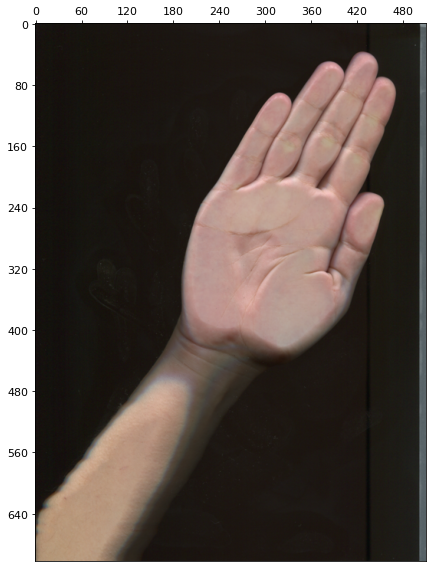

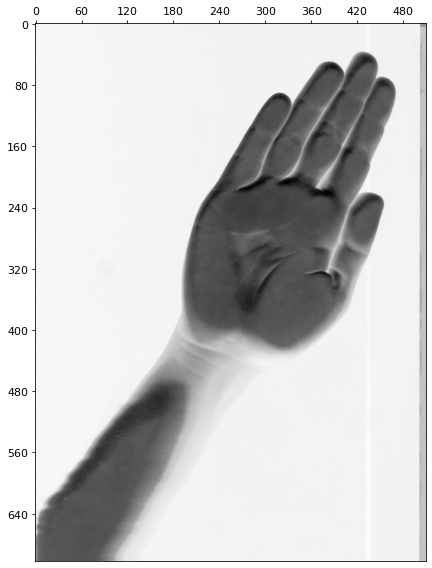

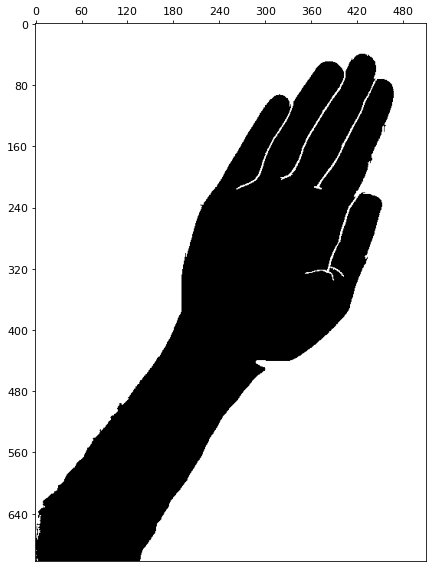

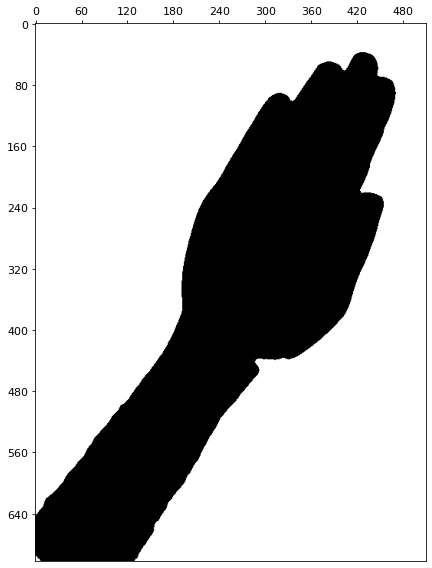

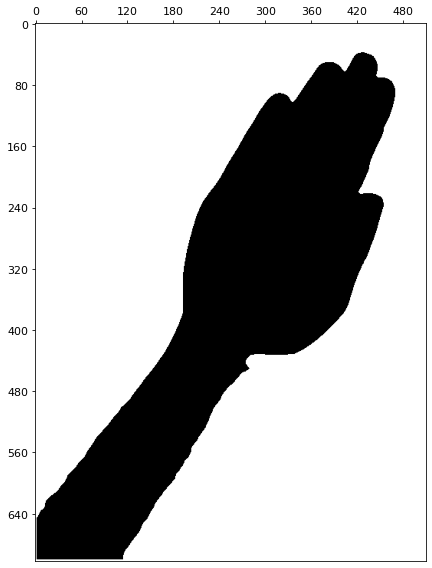

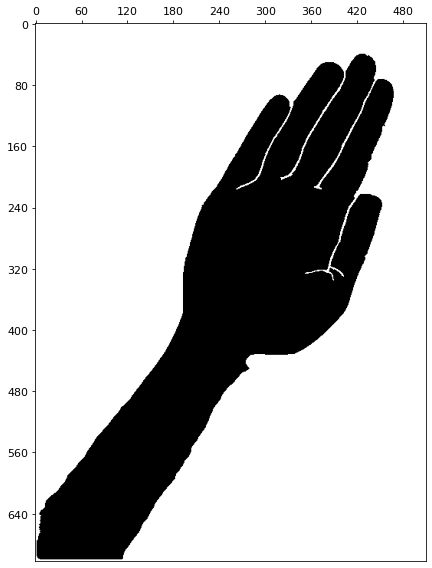

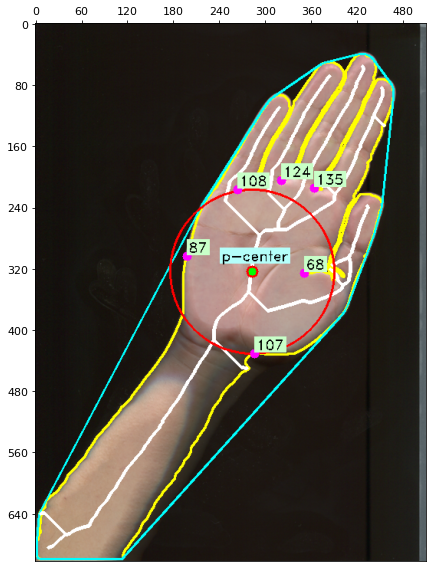

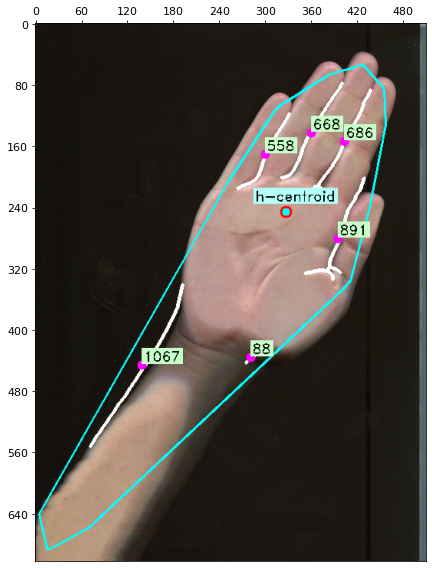

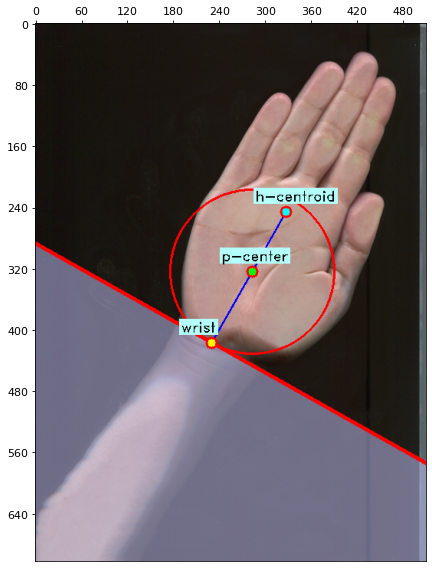

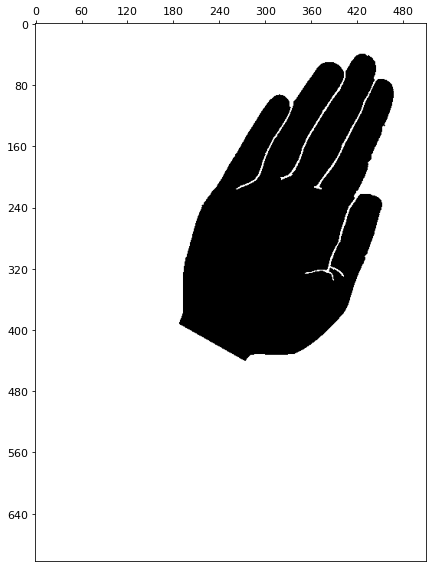

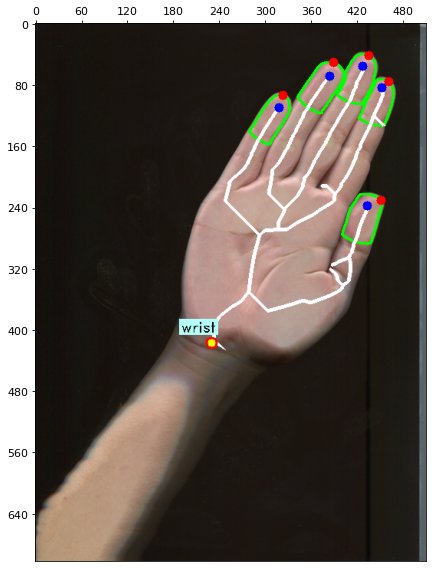

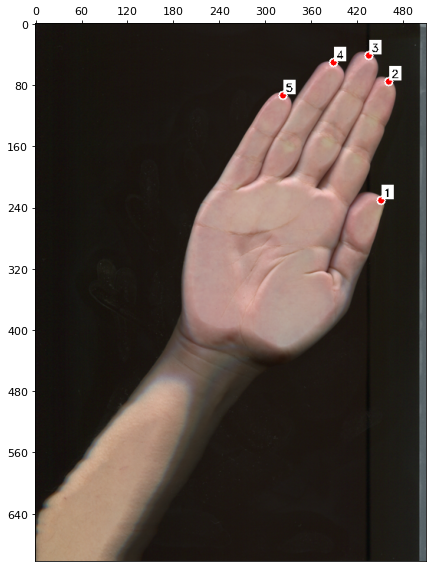

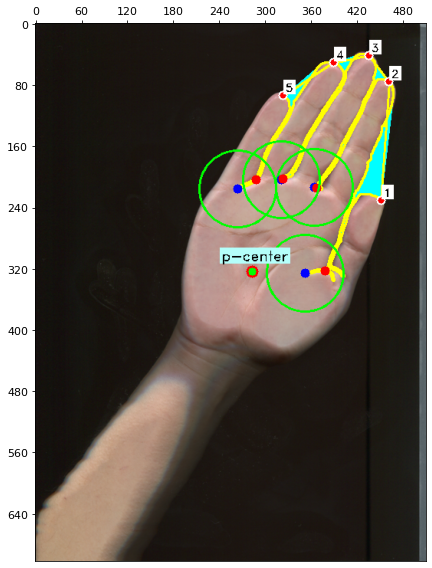

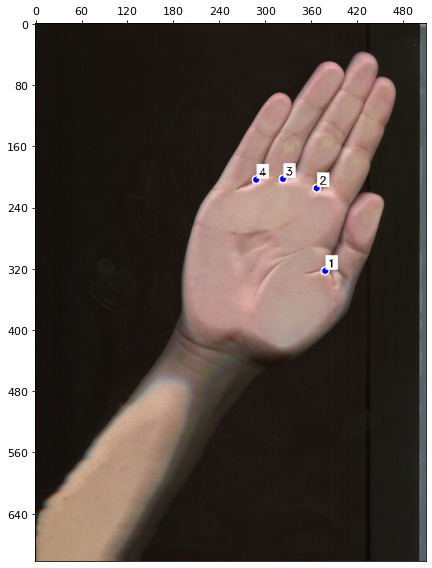

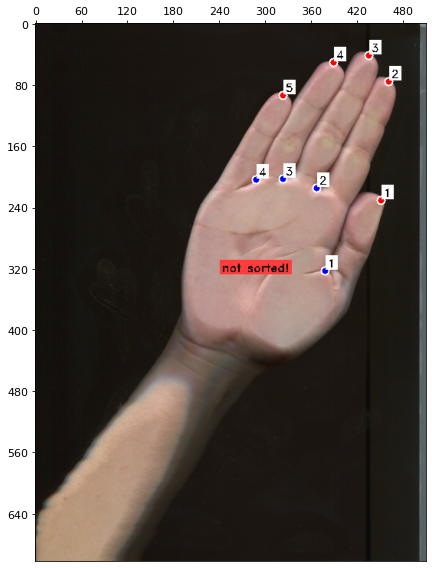

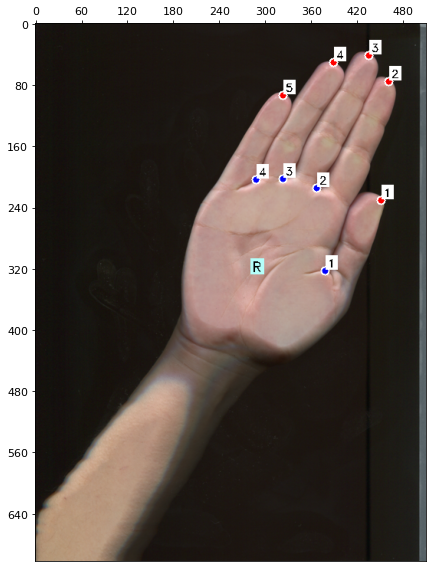

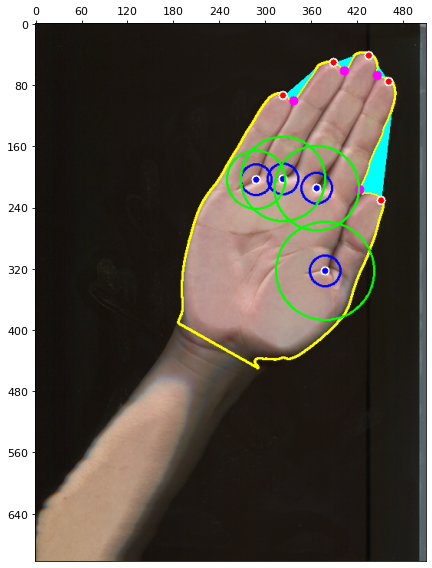

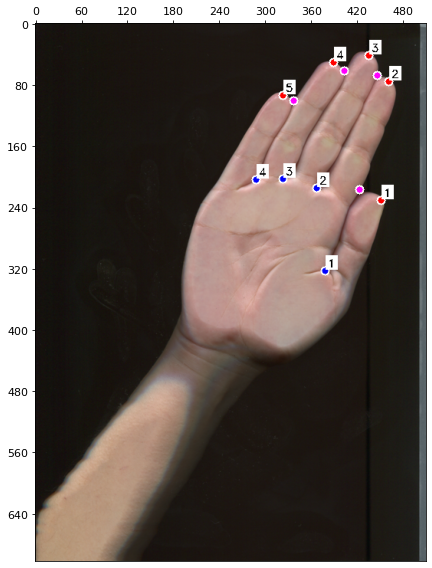

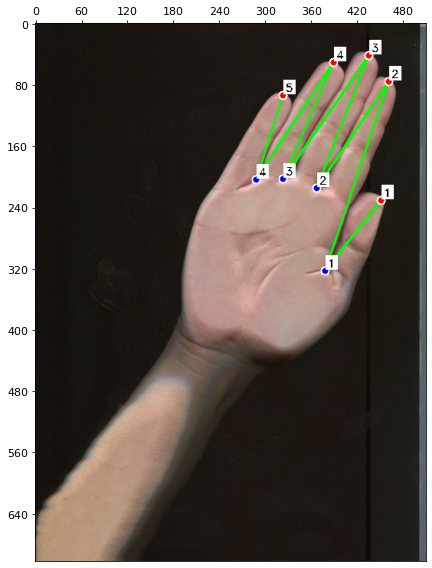

1+2+3+4+5
!,017.tif,T 451 231,T 461 76,T 435 42,T 389 51,T 323 94,V 378 323,V 367 215,V 323 203,V 288 204,?


In [22]:
# parameters
input_folder = 'Training'
vis_folder = 'vis'
output_folder = 'out'

chk_vis = True

# input
name = input()
img = cv2.imread(f'{input_folder}/{name}')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# show input file
show_images_cv([img], [name])

# processing
img_res, gesture, coords, vis_img_arr = hand_points_detection(img, name, vis=chk_vis)
out_info = f'{gesture}\n{coords}'

# output
if chk_vis:
    for i, vis_img in enumerate(vis_img_arr):
        show_images([vis_img], save_path=f'{vis_folder}/vis_{i}_{name}')
print(out_info)

# save
try:
    Image.fromarray(img_res).save(f'{output_folder}/res_{name}')
    with open(f'{output_folder}/Results.txt', 'w') as fout:
        fout.writelines(out_info)
except:
    print('Can not save result!')

# show result file
show_images_cv([img_res], [f'{name} result'])